In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
import pandas as pd
from PIL import Image
from tensorflow.keras import layers
import matplotlib.pyplot as plt

Import from data.csv, which consist the image number and corresponding label and label name

In [222]:
mj_df = pd.read_csv("data.csv")
print('Shape of data:', mj_df.shape)
print(mj_df.head())

Shape of data: (700, 3)
  image-name  label    label-name
0      1.jpg     38  bonus-winter
1      2.jpg     26  characters-8
2      3.jpg      9        dots-9
3      4.jpg     36  bonus-summer
4      5.jpg     28   honors-east


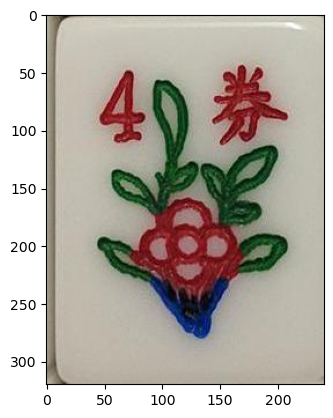

In [223]:
#Display of sample image
img0 = Image.open('images/1.jpg')
plt.imshow(img0)

In [224]:
mj_df['image-path'] = 'images/' + mj_df['image-name']
mj_df.head()

,image-name,label,label-name,image-path
0,1.jpg,38,bonus-winter,images/1.jpg
1,2.jpg,26,characters-8,images/2.jpg
2,3.jpg,9,dots-9,images/3.jpg
3,4.jpg,36,bonus-summer,images/4.jpg
4,5.jpg,28,honors-east,images/5.jpg


In [225]:
print('Mj_DF Label starts at: '+ str(min(mj_df['label'])))
print('Since label starts at 1, subtract 1 to facilitate classification by tensorflow (dense layer output)')
mj_df['label'] -= 1
mj_df.head()

Mj_DF Label starts at: 1
Since label starts at 1, subtract 1 to facilitate classification by tensorflow (dense layer output)


,image-name,label,label-name,image-path
0,1.jpg,37,bonus-winter,images/1.jpg
1,2.jpg,25,characters-8,images/2.jpg
2,3.jpg,8,dots-9,images/3.jpg
3,4.jpg,35,bonus-summer,images/4.jpg
4,5.jpg,27,honors-east,images/5.jpg


In [226]:
# train-test split
train_index = mj_df.sample(frac=0.75,random_state = 320)# 75% train
train_size = train_index.shape[0]
val_index = mj_df.drop(train_index.index)
print('Train')
print(train_index.shape)
print('Val')
print(val_index.shape)

Train
(525, 4)
Val
(175, 4)


In [227]:
batch_size = 16
img_height = 224
img_width = 224

In [228]:
def show_image_sample(ds):
    for n, (image, label) in enumerate(ds.take(4)):
        plt.subplot(2,2,n+1)
        plt.imshow(image[1].numpy().astype("uint8"))
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(np.argmax(label))
    plt.show()
#image[1].numpy().astype("uint8")
def read_image(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image_resized = tf.image.resize(image, [img_height, img_width])
    return image_resized

def get_dataset(dataset_index):
    path_ds = tf.data.Dataset.from_tensor_slices(dataset_index['image-path'])
    image_ds = path_ds.map(read_image, num_parallel_calls=AUTOTUNE)
    label_one_hot = tf.one_hot(dataset_index['label'], num_classes)
    label_ds = tf.data.Dataset.from_tensor_slices(label_one_hot)
    
    paired_ds = tf.data.Dataset.zip((image_ds, label_ds))

    return paired_ds

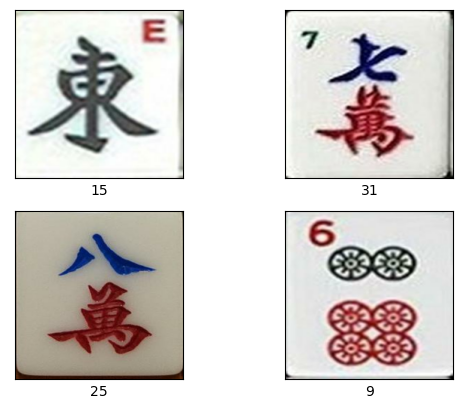

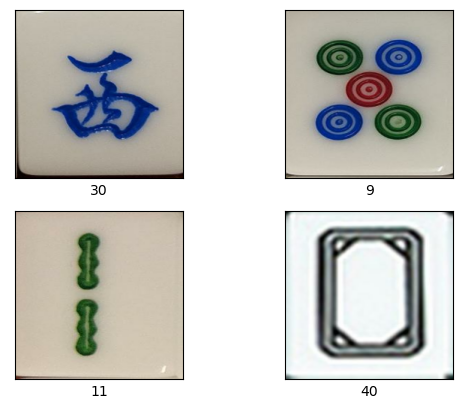

In [230]:
train_ds = get_dataset(train_index)
train_ds = train_ds.batch(batch_size)
val_ds = get_dataset(val_index)
val_ds = val_ds.batch(batch_size)

show_image_sample(train_ds)
show_image_sample(val_ds)

In [231]:
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [232]:
#data normalization and rescaling
data_augmentation = tf.keras.Sequential([
  #layers.Rescaling(1./127.5, offset=-1, input_shape=(img_height, img_width, 3)),
  layers.RandomZoom(.2,.2),
  layers.RandomRotation(0.2),
])

In [233]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [234]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 1280)


In [235]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_25[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [236]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [237]:
num_classes = len(np.unique(mj_df['label']))
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 42)


In [238]:
len(model.trainable_variables)

2

In [248]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
print(x)
x = base_model(x, training=False)
print(x)
x = global_average_layer(x)
print(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), name='tf.math.subtract_20/Sub:0', description="created by layer 'tf.math.subtract_20'")
KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 1280), dtype=tf.float32, name=None), name='mobilenetv2_1.00_224/out_relu/Relu6:0', description="created by layer 'mobilenetv2_1.00_224'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1280), dtype=tf.float32, name=None), name='global_average_pooling2d_6/Mean:0', description="created by layer 'global_average_pooling2d_6'")


In [249]:
#base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'])
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_11 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_20 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_20 (TFOpLa  (None, 224, 224, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                          

In [250]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

11/11 [==============================] - 7s 385ms/step - loss: 4.4007 - accuracy: 0.0286


In [251]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
33/33 [==============================] - 25s 476ms/step - loss: 3.8103 - accuracy: 0.1010 - val_loss: 2.9113 - val_accuracy: 0.2400
Epoch 2/100
33/33 [==============================] - 16s 473ms/step - loss: 2.4887 - accuracy: 0.3162 - val_loss: 2.3537 - val_accuracy: 0.3657
Epoch 3/100
33/33 [==============================] - 16s 477ms/step - loss: 1.8691 - accuracy: 0.4552 - val_loss: 1.9478 - val_accuracy: 0.4571
Epoch 4/100
33/33 [==============================] - 16s 481ms/step - loss: 1.5162 - accuracy: 0.5714 - val_loss: 1.9230 - val_accuracy: 0.4229
Epoch 5/100
33/33 [==============================] - 16s 476ms/step - loss: 1.3222 - accuracy: 0.6210 - val_loss: 1.7335 - val_accuracy: 0.5086
Epoch 6/100
33/33 [==============================] - 15s 473ms/step - loss: 1.1525 - accuracy: 0.6476 - val_loss: 1.6300 - val_accuracy: 0.5257
Epoch 7/100
33/33 [==============================] - 16s 482ms/step - loss: 1.0297 - accuracy: 0.7086 - val_loss: 1.5667 - val_accuracy:

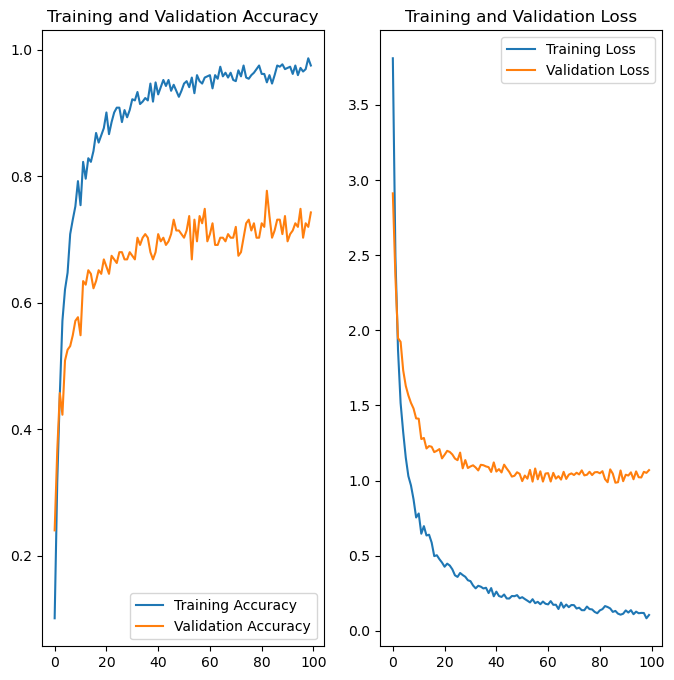

In [252]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [165]:
y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=1)
print(y_pred)
print(train_ds)

10/10 [==============================] - 3s 321ms/step
[37 30 28 22  2 11 23 22 18  6 30  3 29 12 12  9  4 30 23  4 33  0 13 17
 28  0 26  8 32  1  7 11 10 23 30 23 17 14  7  4  3  2 23 23 19  4  3  7
  5 40 33 31  3 19  5  7 14 27 13  5 37 20 21 40 36 28 36  5 12 13 18  0
 16 10  9 39 40 31 18 23  7  5  6  1 16 37 27 18  7 24  5 11 11 10 36 40
 33 17 22 12 21 19  2 18  7  7 35  0 28 29  3 35 23 20 20 12 38 36 33 28
  5 23  3  0 40 33 23 23 15 22 12 23  0 37 41 27 31  7 27  4 28  3 12 26
 25  9  0 37 40 27 31 26 25  8 23 21  0]
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 42), dtype=tf.float32, name=None))>


In [253]:
from sklearn.metrics import classification_report

y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=1)
print(y_pred)
unique_class = np.unique(y_pred)
print(unique_class)
print('No. of unique class: ' + str(len(unique_class)))
y_true = np.concatenate([y for x, y in val_ds], axis=0)
print(np.argmax(y_true, axis = 1))
cr = classification_report(np.argmax(y_true, axis=1), y_pred, output_dict=True)#, target_names=np.argmax(y_true, axis = 1)

11/11 [==============================] - 6s 369ms/step
[30 29 26  2 11 23 21 18  6 30 23  1  3 29 12 12  9  4 30 20  4 33  0 13
 17 28  0 26  8 32  1  7 11 10 23 30 28 17 14  7  4  2 23 20 19  3  7  0
 40 33 31  1 25  5  7 14 27 13 26  0  5 37 37 34 37 28  5 13 11 19 16 10
  9 35 31 23  8  5 36  1 30 37 27 18  7 24  5 11 11 10  9 36 35 33 15 22
 12 21 20 18 18  5  8 34  0 28 29  3 40 23 18 23 14 38 36 33 28 17  5 23
  0 40 33 18 23 15 13 22 12 40 37 41 38 33 16  7  5  4 24 19  9 37 33 25
  8 23 14 13  5 21 18 39 36 39 28 30 41 33 18 20 23 23  2  3  4  5  7 15
 14 14 17 39 34 32 30]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
No. of unique class: 42
[30 29 22  2 11 24 21 18  6 30 23  1  3 29 12 12  9  4 30 20  4 33  0 13
 17 28  0 26  8 32  1 25 11 10 32 30 28 17 14  7  6  2 22 20 19  3  7  0
 40 33 31  1 25  2  7 12 27 11 26  0  6 37 35 34 35 28  5 13 11 19 16 10
  9 38 31 23  8  5  4  2 30 37 27 25  7

In [254]:
result = pd.DataFrame.from_dict(cr).T
display(result)
result.groupby(['support']).mean()

,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,6.000000
1,0.750000,1.000000,0.857143,3.000000
2,1.000000,0.600000,0.750000,5.000000
3,1.000000,1.000000,1.000000,4.000000
4,0.800000,0.666667,0.727273,6.000000
5,0.400000,1.000000,0.571429,4.000000
6,1.000000,0.166667,0.285714,6.000000
7,0.857143,0.857143,0.857143,7.000000
8,0.750000,1.000000,0.857143,3.000000
9,1.000000,0.800000,0.888889,5.000000


,precision,recall,f1-score
support,,,
0.742857,0.742857,0.742857,0.742857
1.000000,0.500000,1.000000,0.666667
2.000000,0.729167,0.937500,0.808333
3.000000,0.666667,0.866667,0.746032
4.000000,0.763636,0.659091,0.662338
5.000000,0.814583,0.725000,0.723115
6.000000,0.920000,0.633333,0.708052
7.000000,0.869048,0.761905,0.800866
8.000000,1.000000,1.000000,1.000000


In [255]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [256]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'])
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_11 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_20 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_20 (TFOpLa  (None, 224, 224, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                          

In [259]:
fine_tune_epochs = 20
total_epochs =  epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 100/120
33/33 [==============================] - 25s 745ms/step - loss: 0.0697 - accuracy: 0.9790 - val_loss: 0.9993 - val_accuracy: 0.7771
Epoch 101/120
33/33 [==============================] - 23s 715ms/step - loss: 0.0476 - accuracy: 0.9867 - val_loss: 1.0831 - val_accuracy: 0.7657
Epoch 102/120
33/33 [==============================] - 21s 633ms/step - loss: 0.0762 - accuracy: 0.9752 - val_loss: 0.9386 - val_accuracy: 0.7771
Epoch 103/120
33/33 [==============================] - 23s 717ms/step - loss: 0.0615 - accuracy: 0.9829 - val_loss: 0.8927 - val_accuracy: 0.7943
Epoch 104/120
33/33 [==============================] - 22s 664ms/step - loss: 0.0571 - accuracy: 0.9829 - val_loss: 1.0313 - val_accuracy: 0.7771
Epoch 105/120
33/33 [==============================] - 24s 731ms/step - loss: 0.0557 - accuracy: 0.9848 - val_loss: 1.0058 - val_accuracy: 0.7600
Epoch 106/120
33/33 [==============================] - 22s 657ms/step - loss: 0.0573 - accuracy: 0.9848 - val_loss: 0.9767 -